# apply a machine learning model on the play time series data

In [1]:
import numpy as np
import pandas as pd
import pickle, time, os, random
from tqdm import tqdm
import tensorflow as tf
import nilearn
import matplotlib.pyplot as plt
import scipy.stats as stats

import csv

#from tensorflow import keras
#from tensorflow.keras import layers
#from functools import partial

In [2]:
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
# where the time_series is aligned to
aligned_to = 'play_end'

# length of time series
ts_length = 13

# read dataframe
data_df = pd.read_pickle(f"./data_df_play_times_aligned_to_{aligned_to}_ts_length_{ts_length}.pkl")
data_df

,subj,run,trial,time_series,trial_type,stimulus
0,600,1,1,"[[0.52923763305877, 0.4749125514767911, 1.6308...",low_reward,received
1,600,1,2,"[[-0.5130513669768391, -0.12752077135186823, 0...",high_threat,not received
2,600,1,3,"[[0.12495972500735775, 0.46859587371426414, 0....",low_reward,received
3,600,1,4,"[[1.244433440880485, -0.3960117860667083, -0.7...",low_reward,received
4,600,1,5,"[[-0.5506318924763463, 0.9748977664840197, 0.0...",high_reward,not received
...,...,...,...,...,...,...
1314,631,8,12,"[[-0.12096713026018335, -1.0052460978428996, 0...",high_threat,not received
1315,631,8,13,"[[-0.03315670862730258, -0.7638145582157421, 0...",high_reward,received
1316,631,8,14,"[[-0.22958929131419836, 0.07129877573336785, -...",high_reward,received
1317,631,8,15,"[[-0.12296967453092122, -0.22173471101338293, ...",high_reward,received


### target classes

In [4]:
#target_classes=[('high_threat', 'received'), 
#                ('low_threat', 'received'),
#                ('high_reward', 'received'),
#                ('low_reward', 'received')]
target_classes=[('high_threat'), ('low_threat'), ('high_reward'), ('low_reward')]
#target_classes=[('high_threat', 'received'), 
#                ('low_threat', 'received')]

### hyperparameters

In [5]:
class ARGS(): pass
args = ARGS()

args.num_subjects = pd.unique(data_df['subj']).shape[0]

args.num_train = round(0.75 * args.num_subjects)
#print(args.num_train)
args.num_test = args.num_subjects - args.num_train
#print(args.num_test)

args.num_units = 32
args.num_classes = len(target_classes)
args.l2 = 1e-2
args.dropout = 0.5
args.learning_rate = 1e-4

args.num_epochs = 150
args.validation_split = 0.2
args.batch_size = 32

args.SEED = 74

#print(args.num_units[0])
#print(args.num_units[1])
#print(args.num_units[2])

### dataset for classification

In [6]:
select_features = np.arange(85)

In [7]:
def get_dataset(data_df, subjs, target_classes, select_features):
    '''
    dataset for machine learning model
    input_samples (X): batch, time, features
    target_vectors (y): batch
    '''
    X = []
    y = []

    subj_data_df = data_df.loc[data_df['subj'].isin(subjs)]

    target_value = dict(zip(target_classes, 
                            list(np.arange(len(target_classes)))))

    for idx_row, row in tqdm(subj_data_df.iterrows()):
        #cond = (row['trial_type'], row['stimulus'])
        cond = (row['trial_type'])
        if cond not in target_classes:
            continue
        X.append(row['time_series'][:, select_features])
        y.append(target_value[cond])

    return np.stack(X, axis=0), np.stack(y, axis=0)

In [8]:
train_subjs = pd.unique(data_df['subj'])[:args.num_train]
test_subjs = pd.unique(data_df['subj'])[args.num_train:]

(X_train, 
 y_train) = get_dataset(data_df=data_df, subjs=train_subjs, target_classes=target_classes, select_features=select_features)
(X_test, 
 y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#print(X_test[0])

935it [00:00, 10029.27it/s]
384it [00:00, 11892.50it/s]

(935, 10, 85)
(935,)
(384, 10, 85)
(384,)


## Lesioning

In [9]:
model = tf.keras.models.load_model('model_GRU_4WayClasfn')

In [55]:
# roiRank file: Structure: cond x roi
file = open('linearSal_roiRank.csv')
csvreader = csv.reader(file)
roiRankRows = []
for row in csvreader:
        roiRankRows.append(row)
file.close()

In [63]:
#iterativemasking

acc_arr_allCond = []

for cond in range(4):
    
    (X_test, 
     y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

    X_test_les = X_test
    acc_arr = []
    for roi in range(85):
        X_test_les[:, :, (int(roiRankRows[cond][roi])-1)] = 0.0

        # testing
        preds = model(X_test_les)

        y_pred = np.argmax(preds, axis=1)
        acc = np.sum(y_pred == y_test)/y_test.shape[0]
        acc_arr.append(acc)
        
    acc_arr_allCond.append(acc_arr)

384it [00:00, 9005.94it/s]
384it [00:00, 12771.59it/s]
384it [00:00, 12515.74it/s]
384it [00:00, 11970.45it/s]


In [72]:
# Shuffling roiRankOrder

null_acc_dist_ub = []
null_acc_dist_lb = []

for cond in range(4):

    null_acc_dist = []
    for iter in range(100):
        np.random.shuffle(roiRankRows[cond])

        (X_test, 
         y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

        X_test_les = X_test
        null_acc_arr = []
        for roi in range(85):
            X_test_les[:, :, (int(roiRankRows[cond][roi])-1)] = 0.0

            # testing
            preds = model(X_test_les)

            y_pred = np.argmax(preds, axis=1)
            acc = np.sum(y_pred == y_test)/y_test.shape[0]
            null_acc_arr.append(acc)
        null_acc_dist.append(null_acc_arr)

    null_acc_dist_ub.append(np.percentile(null_acc_dist,97.5,axis=0))
    null_acc_dist_lb.append(np.percentile(null_acc_dist,2.5,axis=0))

384it [00:00, 9925.27it/s]
384it [00:00, 12076.09it/s]
384it [00:00, 11918.37it/s]
384it [00:00, 12575.35it/s]
384it [00:00, 11856.25it/s]
384it [00:00, 12752.38it/s]
384it [00:00, 7990.66it/s]
384it [00:00, 12613.26it/s]
384it [00:00, 11866.21it/s]
384it [00:00, 12746.12it/s]
384it [00:00, 8039.52it/s]
384it [00:00, 8063.18it/s]
384it [00:00, 12372.96it/s]
384it [00:00, 12002.66it/s]
384it [00:00, 12749.55it/s]
384it [00:00, 12026.86it/s]
384it [00:00, 12796.25it/s]
384it [00:00, 7926.67it/s]
384it [00:00, 12401.16it/s]
384it [00:00, 11810.61it/s]
384it [00:00, 12315.06it/s]
384it [00:00, 12725.18it/s]
384it [00:00, 12669.42it/s]
384it [00:00, 11998.99it/s]
384it [00:00, 12820.39it/s]
384it [00:00, 12067.05it/s]
384it [00:00, 12735.84it/s]
384it [00:00, 11973.30it/s]
384it [00:00, 12520.89it/s]
384it [00:00, 12837.56it/s]
384it [00:00, 12023.27it/s]
384it [00:00, 12693.28it/s]
384it [00:00, 12009.73it/s]
384it [00:00, 12380.85it/s]
384it [00:00, 12723.87it/s]
384it [00:00, 12703.20it/

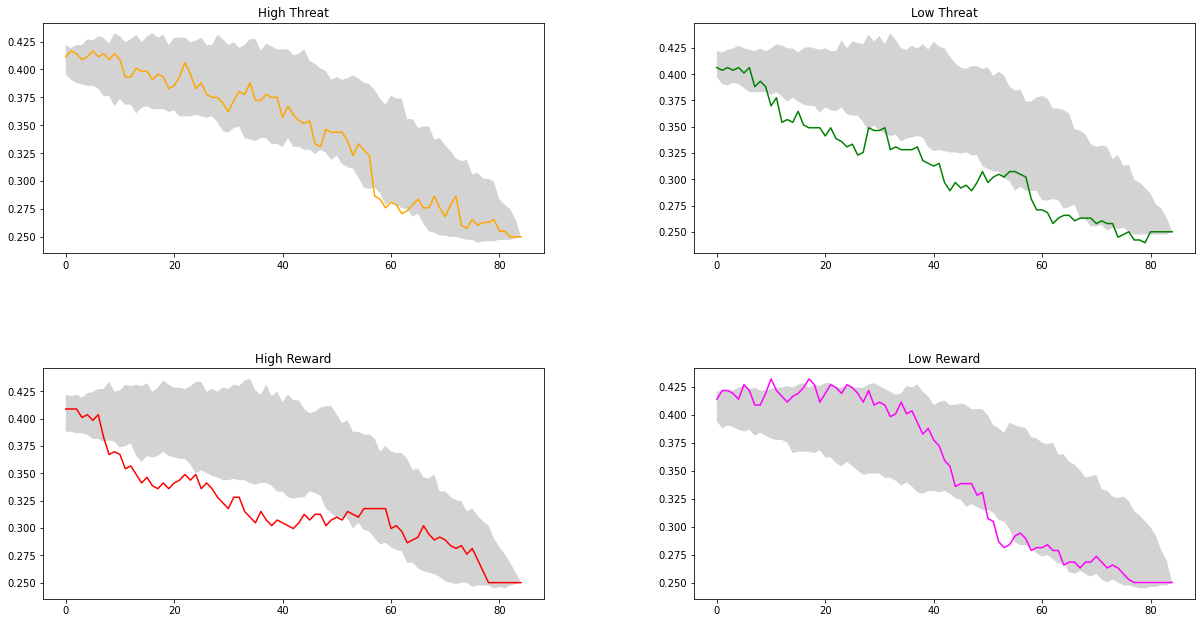

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))    

colorArr = ['orange','green','red','magenta']
titleArr = ['High Threat','Low Threat','High Reward','Low Reward']

for cond in np.arange(4):
    ax = axs[cond//2, np.mod(cond,2)]
    ax.title.set_text(titleArr[cond])
    #ax.plot(np.zeros(10), c='black')
    ax.plot(np.squeeze(acc_arr_allCond[cond]), c=colorArr[cond])
    ax.fill_between(np.arange(85), null_acc_dist_lb[cond], null_acc_dist_ub[cond], alpha=0.5, facecolor='#A9A9A9')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.5)

### ROI Rank based on average response

In [81]:
# roiRank file: Structure: cond x roi
file = open('avgCondROIrank.csv')
csvreader = csv.reader(file)
roiRankRows = []
for row in csvreader:
        roiRankRows.append(row)
file.close()

In [82]:
print(len(roiRankRows))

1


In [83]:
#iterativemasking

(X_test, 
 y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

X_test_les = X_test
acc_arr_avgCond = []
for roi in range(85):
    X_test_les[:, :, (int(roiRankRows[0][roi])-1)] = 0.0

    # testing
    preds = model(X_test_les)
    y_pred = np.argmax(preds, axis=1)
    acc = np.sum(y_pred == y_test)/y_test.shape[0]
    acc_arr_avgCond.append(acc)

# Generating null
    
null_acc_dist = []
for iter in range(100):
    np.random.shuffle(roiRankRows[0])

    (X_test, 
     y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

    X_test_les = X_test
    null_acc_arr = []
    for roi in range(85):
        X_test_les[:, :, (int(roiRankRows[0][roi])-1)] = 0.0

        # testing
        preds = model(X_test_les)

        y_pred = np.argmax(preds, axis=1)
        acc = np.sum(y_pred == y_test)/y_test.shape[0]
        null_acc_arr.append(acc)
    null_acc_dist.append(null_acc_arr)

null_acc_dist_avgCond_ub = np.percentile(null_acc_dist,97.5,axis=0)
null_acc_dist_avgCond_lb = np.percentile(null_acc_dist,2.5,axis=0)

384it [00:00, 7751.34it/s]
384it [00:00, 12564.56it/s]
384it [00:00, 12623.74it/s]
384it [00:00, 12118.98it/s]
384it [00:00, 7808.92it/s]
384it [00:00, 12668.82it/s]
384it [00:00, 8440.35it/s]
384it [00:00, 11916.52it/s]
384it [00:00, 12684.39it/s]
384it [00:00, 12004.45it/s]
384it [00:00, 12725.28it/s]
384it [00:00, 8165.88it/s]
384it [00:00, 12263.67it/s]
384it [00:00, 12074.92it/s]
384it [00:00, 12092.60it/s]
384it [00:00, 12264.23it/s]
384it [00:00, 7406.31it/s]
384it [00:00, 12806.02it/s]
384it [00:00, 12487.21it/s]
384it [00:00, 8064.88it/s]
384it [00:00, 12022.55it/s]
384it [00:00, 12548.60it/s]
384it [00:00, 12688.98it/s]
384it [00:00, 11905.51it/s]
384it [00:00, 12563.58it/s]
384it [00:00, 12222.45it/s]
384it [00:00, 12450.34it/s]
384it [00:00, 12363.18it/s]
384it [00:00, 8251.72it/s]
384it [00:00, 11794.26it/s]
384it [00:00, 11775.55it/s]
384it [00:00, 12462.28it/s]
384it [00:00, 12419.90it/s]
384it [00:00, 12549.87it/s]
384it [00:00, 12534.24it/s]
384it [00:00, 7947.60it/s]


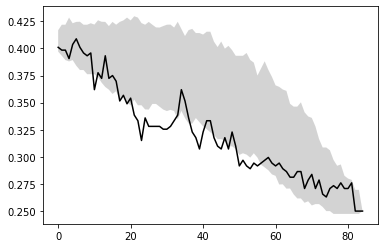

In [85]:
#plt.title.set_text('ROI Order based on Avg.Value across conditions')
plt.plot(np.squeeze(acc_arr_avgCond), c='black')
plt.fill_between(np.arange(85), null_acc_dist_avgCond_lb, null_acc_dist_avgCond_ub, alpha=0.5, facecolor='#A9A9A9')

## Lesioning GB saliency based ROI rank order

In [11]:
# roiRank file: Structure: cond x roi
file = open('gbSalROIrank.csv')
csvreader = csv.reader(file)
roiRankRows = []
for row in csvreader:
        roiRankRows.append(row)
file.close()

In [12]:
#iterativemasking

acc_arr_allCond = []

for cond in range(4):
    
    (X_test, 
     y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

    X_test_les = X_test
    acc_arr = []
    for roi in range(85):
        X_test_les[:, :, (int(roiRankRows[cond][roi])-1)] = 0.0

        # testing
        preds = model(X_test_les)

        y_pred = np.argmax(preds, axis=1)
        acc = np.sum(y_pred == y_test)/y_test.shape[0]
        acc_arr.append(acc)
        
    acc_arr_allCond.append(acc_arr)

384it [00:00, 9573.76it/s]
384it [00:00, 12015.64it/s]
384it [00:00, 12374.29it/s]
384it [00:00, 12129.84it/s]


In [16]:
# Shuffling roiRankOrder

null_acc_dist_ub = []
null_acc_dist_lb = []

for cond in range(4):

    null_acc_dist = []
    for iter in range(100):
        np.random.shuffle(roiRankRows[cond])

        (X_test, 
         y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

        X_test_les = X_test
        null_acc_arr = []
        for roi in range(85):
            X_test_les[:, :, (int(roiRankRows[cond][roi])-1)] = 0.0

            # testing
            preds = model(X_test_les)

            y_pred = np.argmax(preds, axis=1)
            acc = np.sum(y_pred == y_test)/y_test.shape[0]
            null_acc_arr.append(acc)
        null_acc_dist.append(null_acc_arr)

    null_acc_dist_ub.append(np.percentile(null_acc_dist,97.5,axis=0))
    null_acc_dist_lb.append(np.percentile(null_acc_dist,2.5,axis=0))

384it [00:00, 12471.45it/s]
384it [00:00, 11889.07it/s]
384it [00:00, 12671.21it/s]
384it [00:00, 12138.80it/s]
384it [00:00, 12271.24it/s]
384it [00:00, 12024.16it/s]
384it [00:00, 11824.48it/s]
384it [00:00, 12417.32it/s]
384it [00:00, 12152.27it/s]
384it [00:00, 12681.39it/s]
384it [00:00, 12018.51it/s]
384it [00:00, 12704.70it/s]
384it [00:00, 11985.87it/s]
384it [00:00, 12750.16it/s]
384it [00:00, 12265.17it/s]
384it [00:00, 12242.61it/s]
384it [00:00, 12739.67it/s]
384it [00:00, 12092.32it/s]
384it [00:00, 12671.21it/s]
384it [00:00, 12750.86it/s]
384it [00:00, 12416.84it/s]
384it [00:00, 12668.42it/s]
384it [00:00, 12498.26it/s]
384it [00:00, 12418.75it/s]
384it [00:00, 12796.96it/s]
384it [00:00, 12758.44it/s]
384it [00:00, 12025.69it/s]
384it [00:00, 12586.65it/s]
384it [00:00, 12504.47it/s]
384it [00:00, 12184.35it/s]
384it [00:00, 12345.74it/s]
384it [00:00, 12536.29it/s]
384it [00:00, 12509.52it/s]
384it [00:00, 12072.56it/s]
384it [00:00, 12627.01it/s]
384it [00:00, 12321.

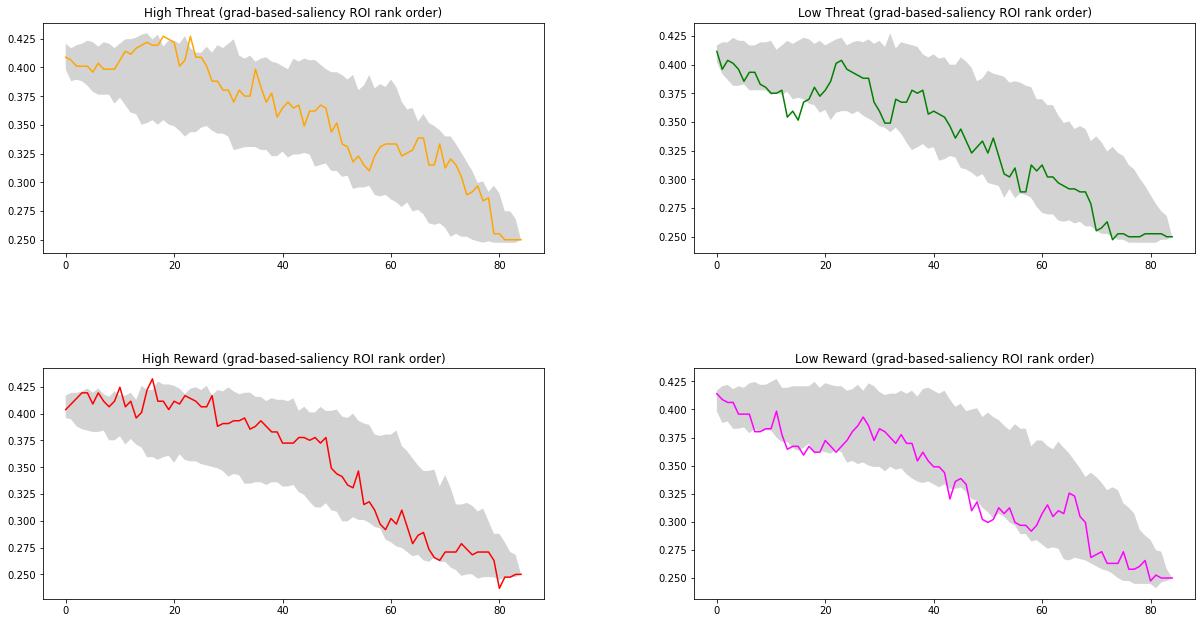

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))    

colorArr = ['orange','green','red','magenta']
titleArr = ['High Threat (grad-based-saliency ROI rank order)','Low Threat (grad-based-saliency ROI rank order)','High Reward (grad-based-saliency ROI rank order)','Low Reward (grad-based-saliency ROI rank order)']

for cond in np.arange(4):
    ax = axs[cond//2, np.mod(cond,2)]
    ax.title.set_text(titleArr[cond])
    #ax.plot(np.zeros(10), c='black')
    ax.plot(np.squeeze(acc_arr_allCond[cond]), c=colorArr[cond])
    ax.fill_between(np.arange(85), null_acc_dist_lb[cond], null_acc_dist_ub[cond], alpha=0.5, facecolor='#A9A9A9')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.5)